# Preparing training data

In [16]:
# -- import packages -- 
from pathlib import Path
import numpy as np
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR

In [17]:
training_data_file_name = 'all_record_2.json'
training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

with open(training_data_file_path, 'r', encoding='utf-8') as f:
    training_data: dict = json.load(f)

# keys = [ int(key) for key in training_data.keys()]
# values = list(training_data.values())
X, y = (np.array(training_data.get('request_number')).reshape(-1, 1), np.array(training_data.get('real_process_time')))

In [18]:
# training_data_file_name = 'data.json'
# training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

# with open(training_data_file_path, 'r', encoding='utf-8') as f:
#     training_data = json.load(f)

# # X, y = np.array(training_data.get('request_number')).reshape(-1, 1), np.array([training_data.get('user_cpu_time')[i] + training_data.get('system_cpu_time')[i] for i in range(len(training_data.get('user_cpu_time')))])
# X, y = (np.array(training_data.get('request_number'))).reshape(-1, 1), np.array(training_data.get('real_processing_time'))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=28
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=30
)

In [19]:
results = []

# Xgboost

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Create XGBoost regression model
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=50,   # 基础学习器（树）的数量
    max_depth=5,        # 树的最大深度
    colsample_bytree=0.8,   # 随机选择特征的比例
    random_state=12,     # 保持结果可复现
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
mea = mean_absolute_error(y_test, y_pred_xgb)
test_mea = np.mean(y_test)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mea}")
print(f"Mean Test Data: {test_mea}")

Mean Squared Error: 0.0011898601726753112
Mean Absolute Error: 0.025974448612821152
Mean Test Data: 5.103079204958988


In [21]:
for name, model, predict_val, predict_test in [
    ("XGBoost", xgb_model, xgb_model.predict(X_val), xgb_model.predict(X_test))
]:
    results.append({
        "Model": name,
        "Val MSE": mean_squared_error(y_val, predict_val),
        "Val MAE": mean_absolute_error(y_val, predict_val),
        "Val R2": r2_score(y_val, predict_val),
        "Test MSE": mean_squared_error(y_test, predict_test),
        "Test MAE": mean_absolute_error(y_test, predict_test),
        "Test R2": r2_score(y_test, predict_test)
    })

print(xgb_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=12, ...)


# Import Packages

In [22]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Other Model
- Linear Regression
- Support Vector Regression
- Lasso Regression
- Ridge Regression

- best

In [23]:
from sklearn.model_selection import GridSearchCV

lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
ridge_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}


lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
best_lasso_alpha = lasso_grid.best_params_['alpha']

ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
best_ridge_alpha = ridge_grid.best_params_['alpha']


In [24]:
model_list = [
    ("Linear Regression", LinearRegression()),
    ("Support Vector Regression", SVR(kernel='rbf')),
    (f"Lasso Regression (alpha={best_lasso_alpha})", best_lasso),
    (f"Ridge Regression (alpha={best_ridge_alpha})", best_ridge),
]

- Fit

In [25]:
for name, model in model_list:
    model.fit(X_train, y_train)
    predict_val = model.predict(X_val)
    predict_test = model.predict(X_test)

    results.append({
        "Model": name,
        "Val MSE": mean_squared_error(y_val, predict_val),
        "Val MAE": mean_absolute_error(y_val, predict_val),
        "Val R2": r2_score(y_val, predict_val),
        "Test MSE": mean_squared_error(y_test, predict_test),
        "Test MAE": mean_absolute_error(y_test, predict_test),
        "Test R2": r2_score(y_test, predict_test)
    })

print(model_list)

[('Linear Regression', LinearRegression()), ('Support Vector Regression', SVR()), ('Lasso Regression (alpha=10)', Lasso(alpha=10, max_iter=10000)), ('Ridge Regression (alpha=100)', Ridge(alpha=100))]



# Print Data

In [26]:
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

                          Model   Val MSE   Val MAE    Val R2  Test MSE  \
0                       XGBoost  0.001142  0.026167  0.999920  0.001190   
1             Linear Regression  0.268460  0.447393  0.981304  0.243800   
2     Support Vector Regression  0.002389  0.040930  0.999834  0.002457   
3   Lasso Regression (alpha=10)  0.268465  0.447399  0.981303  0.243800   
4  Ridge Regression (alpha=100)  0.268460  0.447393  0.981304  0.243800   

   Test MAE   Test R2  
0  0.025974  0.999914  
1  0.420016  0.982427  
2  0.042024  0.999823  
3  0.420020  0.982427  
4  0.420016  0.982427  


# Save Result

In [27]:
results_df.to_csv('../../model_results_2.csv', index=False)
print("保存完成：model_results_2.csv")

保存完成：model_results_2.csv


# Show in Fig

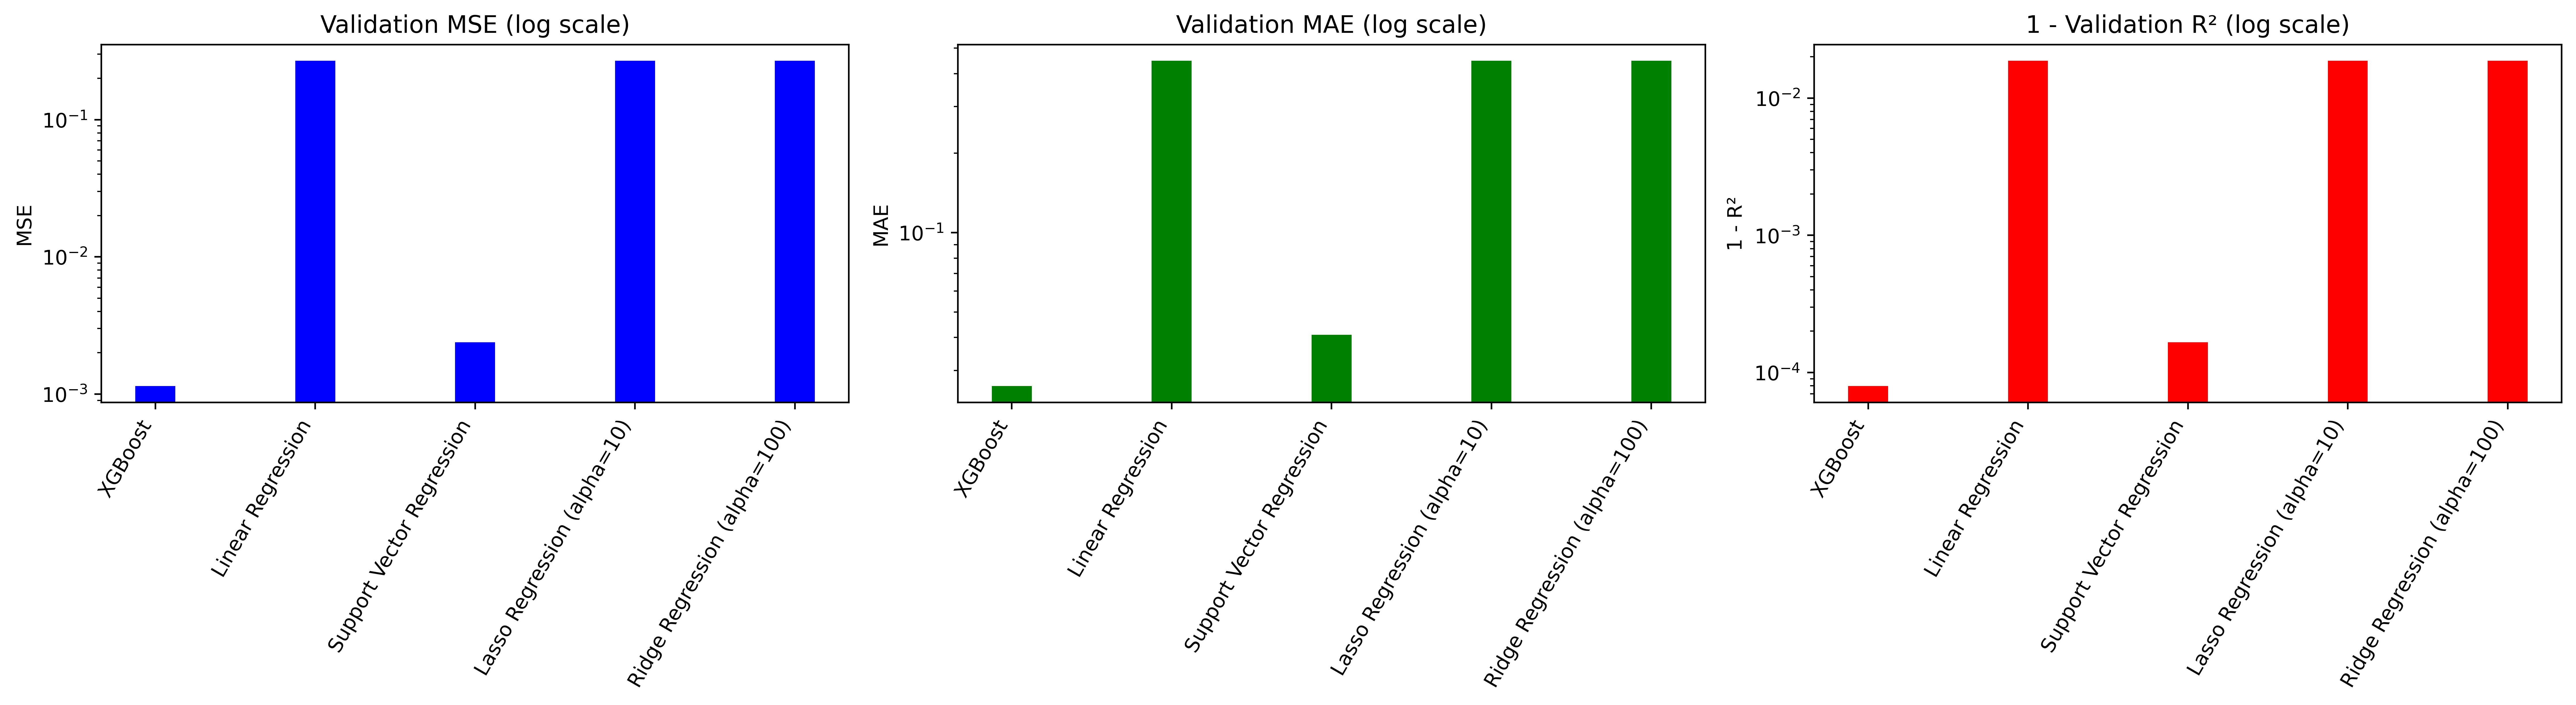

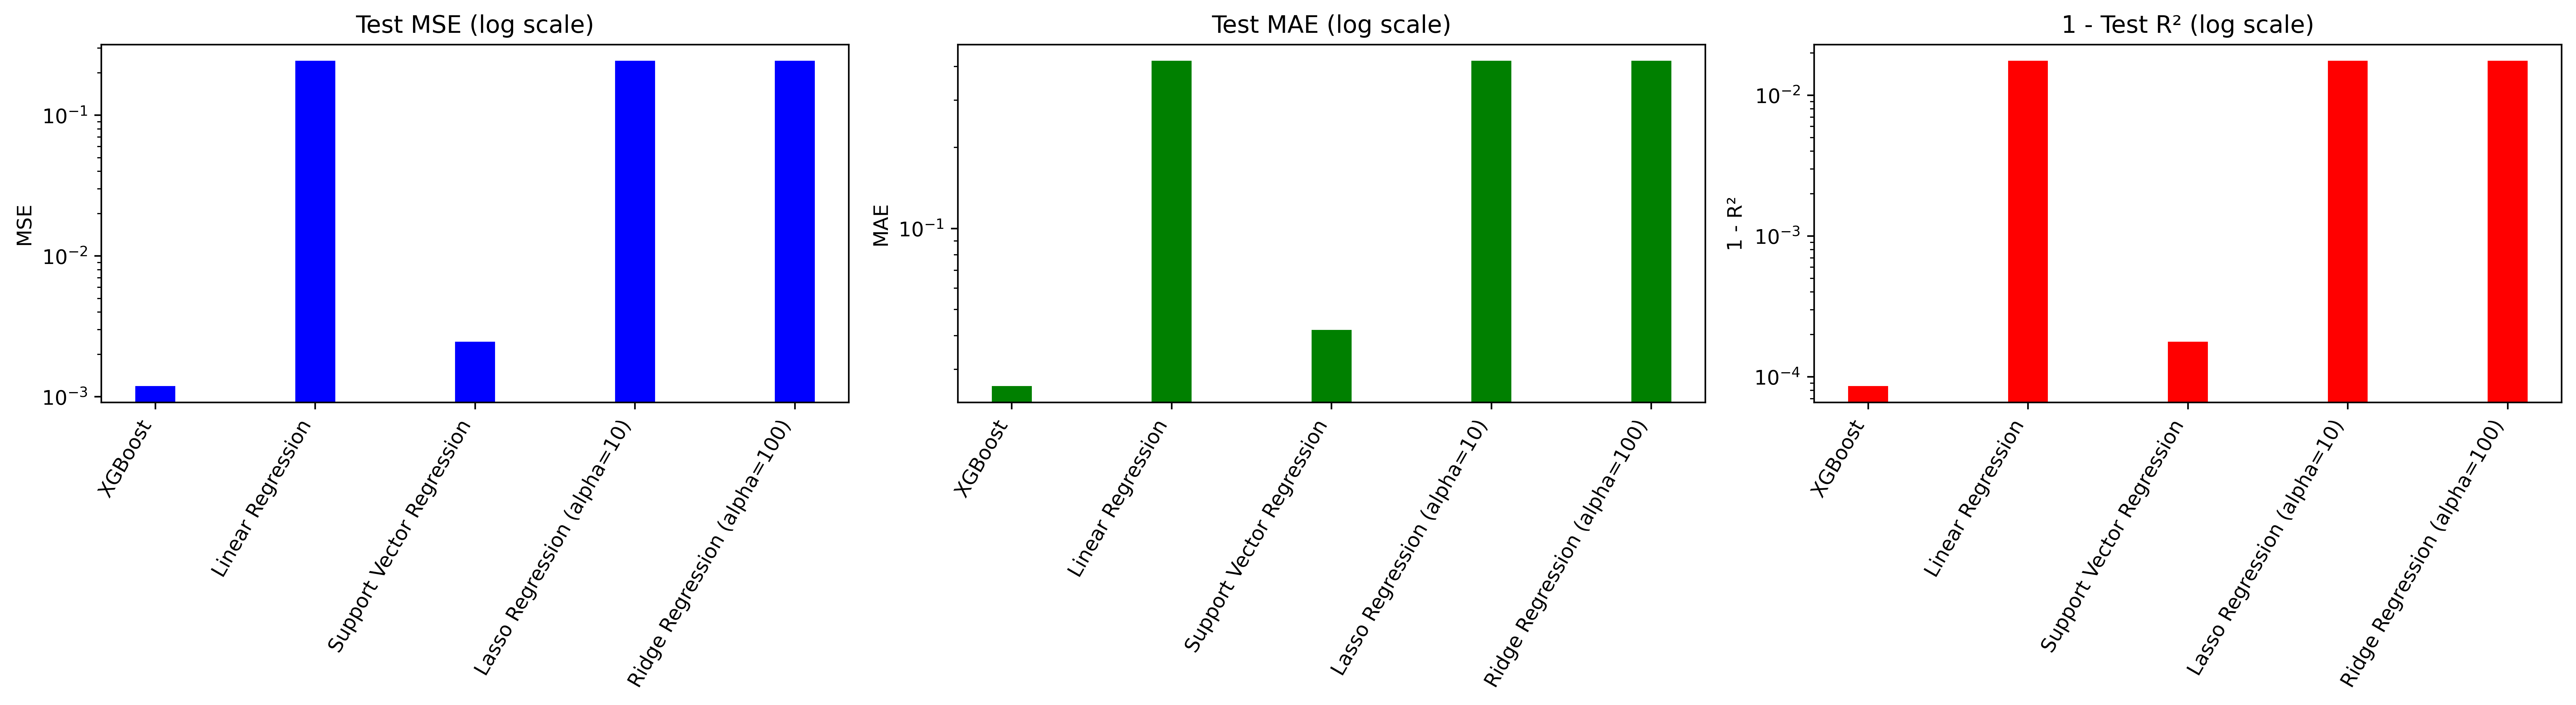

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Load evaluation results
results_df = pd.read_csv(Path('../../model_results_2.csv'))
models = results_df['Model'].tolist()

# Prepare Validation metrics
val_mse = results_df['Val MSE'].tolist()
val_mae = results_df['Val MAE'].tolist()
val_r2 = results_df['Val R2'].tolist()
val_r2_residuals = [(1 - val) for val in val_r2]

# Prepare Test metrics
test_mse = results_df['Test MSE'].tolist()
test_mae = results_df['Test MAE'].tolist()
test_r2 = results_df['Test R2'].tolist()
test_r2_residuals = [(1 - val) for val in test_r2]

# Model index
x = np.arange(len(models))
width = 0.25

# Validation Set Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=500)

axs[0].bar(x, val_mse, width, color='blue')
axs[0].set_yscale('log')
axs[0].set_title("Validation MSE (log scale)")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=60, ha='right')
axs[0].set_ylabel('MSE')

axs[1].bar(x, val_mae, width, color='green')
axs[1].set_yscale('log')
axs[1].set_title("Validation MAE (log scale)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=60, ha='right')
axs[1].set_ylabel('MAE')

axs[2].bar(x, val_r2_residuals, width, color='red')
axs[2].set_yscale('log')
axs[2].set_title("1 - Validation R² (log scale)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=60, ha='right')
axs[2].set_ylabel('1 - R²')

plt.tight_layout()
plt.show()

# Test Set Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=500)

axs[0].bar(x, test_mse, width, color='blue')
axs[0].set_yscale('log')
axs[0].set_title("Test MSE (log scale)")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=60, ha='right')
axs[0].set_ylabel('MSE')

axs[1].bar(x, test_mae, width, color='green')
axs[1].set_yscale('log')
axs[1].set_title("Test MAE (log scale)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=60, ha='right')
axs[1].set_ylabel('MAE')

axs[2].bar(x, test_r2_residuals, width, color='red')
axs[2].set_yscale('log')
axs[2].set_title("1 - Test R² (log scale)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=60, ha='right')
axs[2].set_ylabel('1 - R²')

plt.tight_layout()
plt.show()


In [29]:
print(models)
print(model_list)
print(results)

['XGBoost', 'Linear Regression', 'Support Vector Regression', 'Lasso Regression (alpha=10)', 'Ridge Regression (alpha=100)']
[('Linear Regression', LinearRegression()), ('Support Vector Regression', SVR()), ('Lasso Regression (alpha=10)', Lasso(alpha=10, max_iter=10000)), ('Ridge Regression (alpha=100)', Ridge(alpha=100))]
[{'Model': 'XGBoost', 'Val MSE': 0.001141826959898594, 'Val MAE': 0.026167345764869124, 'Val R2': 0.999920480713387, 'Test MSE': 0.0011898601726753112, 'Test MAE': 0.025974448612821152, 'Test R2': 0.9999142346451557}, {'Model': 'Linear Regression', 'Val MSE': 0.2684601995393121, 'Val MAE': 0.44739269899335904, 'Val R2': 0.98130385399794, 'Test MSE': 0.24379982613053489, 'Test MAE': 0.42001596745771574, 'Test R2': 0.9824268606688069}, {'Model': 'Support Vector Regression', 'Val MSE': 0.0023891800509657658, 'Val MAE': 0.04093039512178391, 'Val R2': 0.9998336123599151, 'Test MSE': 0.002456538821799974, 'Test MAE': 0.042024138400754876, 'Test R2': 0.9998229321994476}, {'

# Save model

In [30]:
print(xgb_model)
# xgb_model.save_model(Path() / 'modelsfile' / 'xgboost_newest_model_5.json')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=12, ...)
